## Part 2 - 2 Stream Solutions

In this section of the project the exponential distribution created in the previous section is used to build up a full similation of single cloud layer.

### Build up functions

Below are the first building blocks for the simulation. These take the exponential distribution and use that to make a full function to pick a random optical depth called, `draw_random_tau`. Next is helper function, `change_direction`, that changes the direction given the current direction. All of this together leads to the function `track_photon` which is the crux of the two stream method. The method here includes the check for absorption, but the first tests will now use this.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=False)
%matplotlib inline

TRANSMITTED = 1
REFLECTED = 0
ABSORBED = 2

DOWN = 1
UP = -1

def exp_dist(x):
    return -np.log(1-x)

def draw_random_tau():
    xi = np.random.random()
    tau = exp_dist(xi)
    return tau

def change_direction(current_dir):
    if(current_dir == DOWN):
        return UP
    else:
        return DOWN

# Will return 1 if transmitted, 0 if reflected, 2 if absorbed, and -1 for issues
def track_photon(tau_bar, g_asym, absorb_wpi):
    
    #Make first step of a random depth using the exponential distribution
    depth = draw_random_tau()
    
    #Make useful variables
    prob_forward = (1+g_asym)/2
    direction = DOWN
    #print("First tau is "+str(depth))
    
    #Here is the check to keep running while depth lies within the cloud layer
    while(depth>0 and depth<tau_bar):
        absorb_random = np.random.random()
        if(absorb_random > absorb_wpi):
            #print("Photon Absorbed!")
            return ABSORBED
        dir_random = np.random.random()
        if(dir_random > prob_forward):
            #print("Direction Changed")
            direction = change_direction(direction)
        next_tau = draw_random_tau()
        depth = depth + direction*next_tau
        #print("New depth: "+str(depth))
    if(depth>tau_bar):
        #print("Photon Transmitted!")
        return TRANSMITTED
    elif(depth<0):
        #print("Photon Reflected!")
        return REFLECTED
    else:
        return -1

Now that the fundamentals for one photon tracking is available a full simulation can be run. Here the function is given the parameters of the number of photons to run, `num_photons`, the depth of the cloud, $\bar{\tau}$ given as `tau_bar`, the asymmetry parameter g, given as `g_asym`, and finally the single scattering albedo, $\varpi$, given as `absorb_wpi`.

The function below called `full_sim` runs the given number of photons and returns the percentage reflected, transmitted, and absorbed.

In [2]:
def full_sim(num_photons, tau_bar, g_asym, absorb_wpi): 
    
    #Create counter variables to track photon results
    reflect_count = 0
    trans_count = 0
    absorb_count = 0
    
    #print("Starting sim for tau_bar = "+str(tau_bar)  +" and g="+str(g_asym) + " and curly pi = " + str(absorb_wpi))
    
    #Run the simulation and increment the appropriate counter depending on the result of a photon tracking.
    for i in range(num_photons):
        result = track_photon(tau_bar, g_asym, absorb_wpi)
        if(result == TRANSMITTED):
            trans_count = trans_count+1
        elif(result == REFLECTED):
            reflect_count = reflect_count+1
        elif(result == ABSORBED):
            absorb_count = absorb_count +1
        else:
            print("Error in photon tracking")
            
    #Return a percentage for each type of result
    return [reflect_count/num_photons, trans_count/num_photons, absorb_count/num_photons]

Now that all of the functions have been built, the two code blocks below use them to run a simulation. First the taus to be used within different simulations are created as a linear array from 1-100 and then the storage arrays for the reflected, transmitted, and absorbed percentages are also created. The for loop in the first block then runs all of the experiments and records the results in the appropriate arrays. The second block then calculates the exact answers and plots the results. The shown figure was done with 100,000 photons which was chosen as will be discussed in the next subsection. Note that this code is nicely readable and short due to the use of helper and incremental functions above.

In [5]:
#Setup arrays for storing information
num_taus = 50
tb = np.linspace(1, 100, num_taus)
ref_no_ab = np.zeros(num_taus)
tran_no_ab = np.zeros(num_taus)
absorb_no_ab = np.zeros(num_taus)

#Setup simulation parameter and note with wpi = 1 there is no absorption
wpi = 1
g = 0.85
n_photons = 1000

#Run the simulation for all taus created in the tb array.
for i in range(num_taus):
    results = full_sim(n_photons, tb[i], g, wpi)
    ref_no_ab[i] = results[0]
    tran_no_ab[i] = results[1]
    absorb_no_ab[i] = results[2]

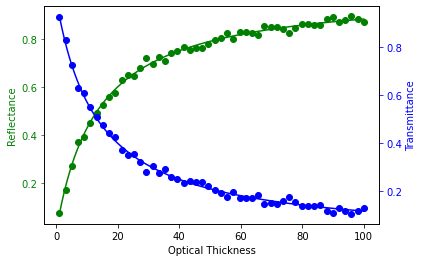

In [6]:
#Plot the reflected Results and exact solution
t_range = np.linspace(1,100, 1000)
fig, ax1 = plt.subplots()
ax1.plot(tb, ref_no_ab, 'og', label="Reflected")
ax1.plot(t_range, t_range/(2/(1-g)+t_range), "-g")
ax1.set_ylabel('Reflectance', color='g')
ax1.tick_params('y', colors='g')

ax1.set_xlabel("Optical Thickness")

#Plot the Transmitted Results and exact solution
ax2 = ax1.twinx()
ax2.plot(tb, tran_no_ab, 'ob', label="Transmitted")
ax2.plot(t_range, 1/((1-g)*t_range/2+1), "-b", label="Transmitted True")
ax2.set_ylabel('Transmittance', color='b')
ax2.tick_params('y', colors='b')

#### Figure 2.1
Results of the two-stream simulation with no absorption run with 100,000 photons with the simulation results shown as dots and the true solution a solid line underneath.

### Determining Convergence Level
Below is the code that was used to test for a desired convergence level. Here the square root was added during plotting so is not included in the first code block, and from this the measure of less than 1% error ($10^{-3}$) was chosen as the acceptable error for convergence. This is visible on the graph and occured around the 100,000 photon range. Additionally note that without abosorption, the error from exact will be the same for both transmitted and reflected as the two exact functions are linked and add up to 1, i.e. if one is over by 0.5% then the other must be under by 0.5% and this will give the same RMS for both functions being above or below. This is why only one line is visible in the graph. Both are printed, but they are in fact the same value. 

In [59]:
from sklearn.metrics import mean_squared_error

#Set up arrays and values of photons to be run
exps = [1000, 5000, 10000, 50000, 100000, 500000]
r_error = np.zeros(len(exps))
t_error = np.zeros(len(exps))
it = 0

#Run the simulation for each number of photons and record the mean squared error after each run.
for k in exps:
    n_photons = k
    for i in range(num_taus):
        results = full_sim(n_photons, tb[i], g, wpi)
        tran_no_ab[i] = results[1]
        ref_no_ab[i] = results[0]
    t_error[it] = mean_squared_error(tran_no_ab, 1/((1-g)*tb/2+1))
    r_error[it] = mean_squared_error(ref_no_ab, tb/(2/(1-g)+tb))
    print("Done with " + str(k))
    it = it+1                        

Done with 1000
Done with 5000
Done with 10000
Done with 50000
Done with 100000
Done with 500000
Done with 1000000


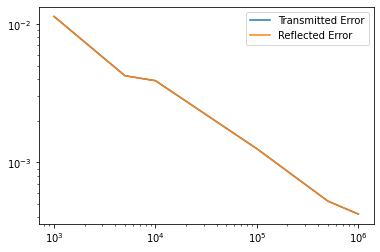

In [60]:
plt.subplot(211)
plt.loglog(exps, np.sqrt(t_error), label="Transmitted Error")

plt.subplot(212)
plt.loglog(exps, np.sqrt(r_error), label="Reflected Error")
plt.legend()
plt.xlabel("Number of Photons")
plt.ylabel("RMS Error")

#### Figure 2.2
The error from true of transmitted and reflected of the 2-stream simulation. Error is along the y-axis and number of photons along the x-axis. Note only one line is visible as the errors are exactly the same

### 2-Stream Solution Using Absorption
The below shows the exact solution for absorption. The simulation code below is the same as was used in the above 2-stream solution, the difference is now the variable `wpi` as the single scattering albedo is set below the value of 1.

Using true solutions:
\begin{align*}
\text{Transmitted} = F_\downarrow (\bar{\tau}) = \bar{A} R_\infty e^{K\bar{\tau}} + \bar{B} e^{-K\bar{\tau}} \\\\
\text{Reflected from Below} = F_\uparrow (\tau=0) = \bar{A} + \bar{B}  R_\infty \\\\
R_\infty = \frac{\sqrt{1-\varpi g}-\sqrt{1-\varpi}}{\sqrt{1-\varpi g}+\sqrt{1-\varpi}} \\\\
K = \sqrt{(1-\varpi g)(1-\varpi)}
\end{align*}
With the following defined:
\begin{align*}
\bar{A} = \frac{F_0 ( R_\infty - R_g ) e^{-K\bar{\tau}}}{R_\infty ( R_\infty-R_g ) e^{-K\bar{\tau}} - ( 1 - R_g R_\infty) e^{K\bar{\tau}}} \\\\
\bar{B} = \frac{-F_0 ( 1 - R_g R_\infty ) e^{K\bar{\tau}}}{R_\infty ( R_\infty-R_g ) e^{-K\bar{\tau}} - ( 1 - R_g R_\infty) e^{K\bar{\tau}}} \\\\\
R_g = \text{Albedo of Surface below the layer}  = 0
\end{align*}

In [23]:
#Run the simulation
num_taus = 100
tb = np.linspace(1, 100, num_taus)
ref = np.zeros(num_taus)
tran = np.zeros(num_taus)
absorb = np.zeros(num_taus)

#Set Simulation Parameters
wpi = 0.9 #This is the one that define absorption.
g = 0.85
n_photons = 100000

#Run the simulation and record the results
for i in range(num_taus):
    results = full_sim(n_photons, tb[i], g, wpi)
    ref[i] = results[0]
    tran[i] = results[1]
    absorb[i] = results[2]

In [24]:
#Create the exact solutions using the same parameters defined in the above block
R_g = 0
R_inf = (np.sqrt(1-wpi*g)-np.sqrt(1-wpi))/(np.sqrt(1-wpi*g)+np.sqrt(1-wpi))
K = np.sqrt((1-wpi*g)*(1-wpi))
A_numerator = (R_inf-R_g)*np.exp(-K*tb)
B_numerator = -(1-R_inf*R_g)*np.exp(K*tb)
denominator = R_inf*(R_inf-R_g)*np.exp(-K*tb) - (1 - R_inf*R_g)*np.exp(K*tb)
A_bar = np.divide(A_numerator, denominator)
B_bar = np.divide(B_numerator, denominator)
T_true = np.multiply(A_bar, R_inf*np.exp(K*tb))+ np.multiply(B_bar, np.exp(-K*tb))
R_true = A_bar+B_bar*R_inf

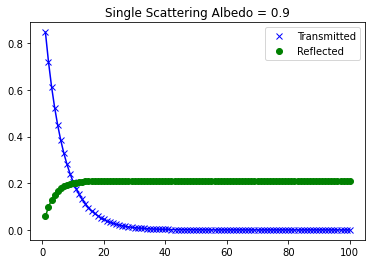

In [28]:
#Plot the results!
plt.plot(tb, T_true, 'b-')
plt.plot(tb, tran, 'bx', label="Transmitted")
plt.plot(tb, R_true, 'g-')
plt.plot(tb, ref, 'go', label="Reflected")
plt.title("Single Scattering Albedo = 0.9")
plt.legend()

#### Figure 2.3
Results of the two-stream simulation with absorption run with 100,000 photons with the simulation results shown as dots and the true solution a solid line underneath.

### Determining Convergence - With Absorption

Here again, using the metric of 0.1% error, the same values of 100,000-300,000 photons can be used to achieve this level of accuracy. as shown in the plot below. This code is nearly identitcal to the code above, but as the single scattering albedo was set to a value less than one this will now compare the the absorbing true answers calculated above.

In [49]:
from sklearn.metrics import mean_squared_error

exps = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
t_error_full = np.zeros(7)
r_error_full = np.zeros(7)
t_error_full[6] = t_error[0]
r_error_full[6] = r_error[0]
it = 0
for k in exps[0:6]:
    n_photons = k
    for i in range(num_taus):
        results = full_sim(n_photons, tb[i], g, wpi)
        tran[i] = results[1]
        ref[i] = results[0]
    t_error_full[it] = mean_squared_error(tran, T_true)
    r_error_full[it] = mean_squared_error(ref, R_true)
    print("Done with "+str(exps[it]))
    it = it+1           
    #print("R error:"+str(r_error[it]))

Done with 1000
Done with 5000
Done with 10000
Done with 50000
Done with 100000
Done with 500000


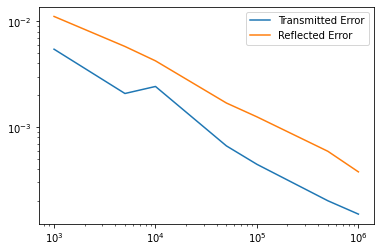

In [52]:
plt.loglog(exps, np.sqrt(t_error_full), label="Transmitted Error")
plt.loglog(exps, np.sqrt(r_error_full), label="Reflected Error")
plt.legend()

#### Figure 2.4
The error from true of transmitted and reflected of the 2-stream simulation including absoption. Error is along the y-axis and number of photons along the x-axis.